In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
path = './house/'
name = 'train.csv'

In [4]:
data = pd.read_csv(path+name)

In [5]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [28]:
df_sub = data[['LotArea','SalePrice']].sort_values(by='SalePrice')
X = np.array(df_sub.SalePrice) 
Y = np.array(df_sub.LotArea)

Y_mean = Y.mean()
Y_std = Y.std()
Y_norm = (Y-Y_mean)/Y_std
X = (X - X.mean())/X.std()

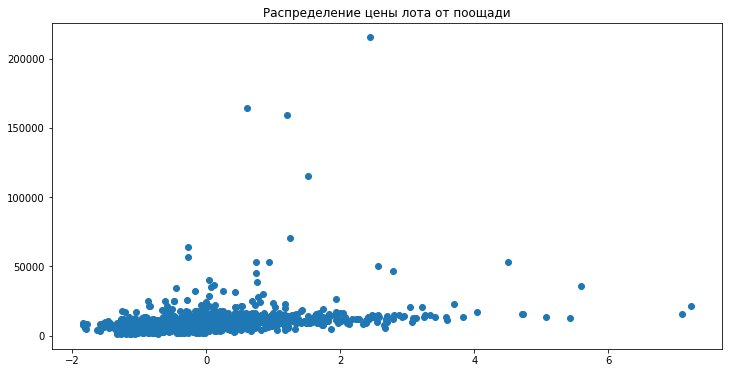

In [12]:
plt.figure(figsize = (12,6))
plt.scatter(X,Y)
plt.title('Распределение цены лота от поощади')
plt.show()

## Находим степень многочлена


In [13]:
m = 0
W = [1, 1]
m_list = []
Y_pred_list = []
W_list = []
H_list = []
while abs(W[-1]) > 10**(-3) and abs(W[-2]) > 10**(-3):
    m = m + 1
    H = []
    for x in X:
        row = [x**i for i in range(m+1)]
        H.append(row)
    
    H = np.array(H)
    H_list.append(H)
    
    W = np.dot(np.dot(np.linalg.inv(np.dot(H.T,H)),H.T),Y)
    Y_pred_list.append(np.dot(H,W))
    W_list.append(W)
    m_list.append(m)
Y_pred_list = Y_pred_list[:-2]
m_list = m_list[:-2]
W_list = W_list[:-2]
H_list = H_list[:-2]

In [16]:
m_res = m_list[-2]
Y_pred_res = Y_pred_list[-2]
W_res = W_list[-2]
H_res = H_list[-2]
print(f'Степень многочлена: {m_res}')

Степень многочлена: 14


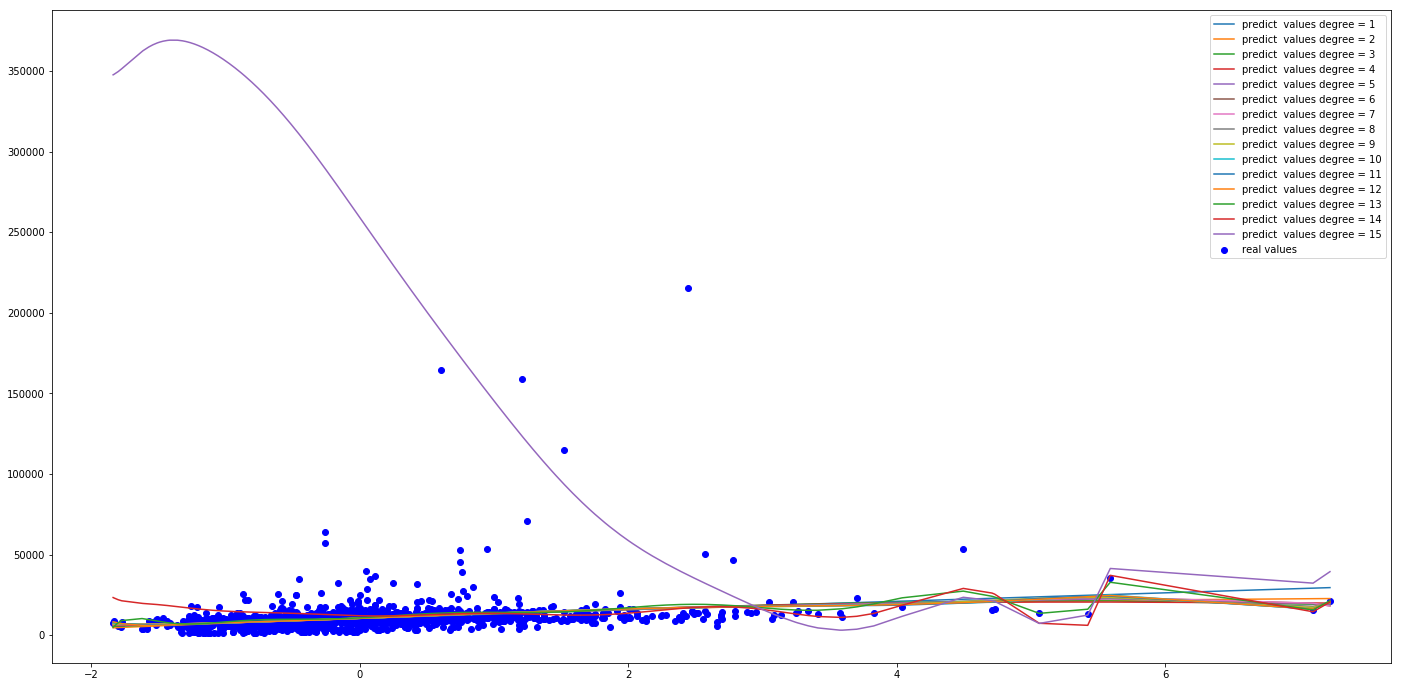

In [17]:
plt.figure(figsize = (24,12))
plt.scatter(X,Y,color='blue', label="real values")
for Y_pred,m in zip(Y_pred_list, m_list):
    plt.plot(X,Y_pred,label=f"predict  values degree = {m}")
plt.legend()
plt.show()

### Считаем $R^2$

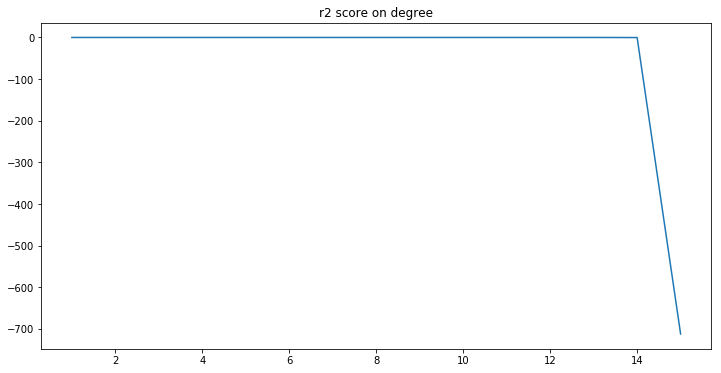

In [18]:
from sklearn.metrics import r2_score
r2_list = []
for Y_pred in Y_pred_list:
    r2 = r2_score(Y,Y_pred)
    r2_list.append(r2)
plt.figure(figsize=(12,6))
plt.plot(m_list,r2_list)
plt.title('r2 score on degree')
plt.show()

In [19]:
E = Y - Y_pred_res

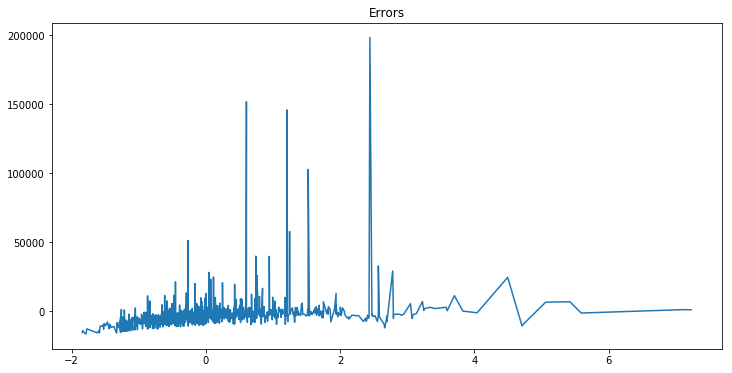

In [20]:
plt.figure(figsize=(12,6))
plt.plot(X,E)
plt.title('Errors')
plt.show()

### Провекра ошибок на нормальность 

In [21]:
from scipy.stats import shapiro

In [22]:
alpha = 0.05

In [23]:
st, p = shapiro(E)
print('p-values = ', p)
answer = 'Не нормальное распределение' if p < alpha else 'Нормальное распределение'
print(answer)

p-values =  0.0
Не нормальное распределение


In [24]:
from scipy.stats import normaltest
st, p = normaltest(E)
print('p-values = ', p)
answer = 'Не нормальное распределение' if p < alpha else 'Нормальное распределение'
print(answer)

p-values =  0.0
Не нормальное распределение


### Находим М-оценки Хубера и Тьюки

In [25]:
# delta_Hubera =  1.345*Y_std/2 + Y_mean
# delta_Tukey = 4.6851*Y_std/2 + Y_mean
delta_Hubera =  1.345/2
delta_Tukey = 4.6851/2

def huber(u):
    
    return u**2/2 if abs(u) <= delta_Hubera else delta_Hubera*(abs(u) - delta_Hubera/2)

def tukey(u):
    return 1-(1-(u/delta_Tukey)**2)**3 if abs(u) < delta_Tukey else 1

def func_min_huber(theta):
    return np.sum( [ huber( y - np.sum( theta * h )) for y, h in zip(Y_norm,H_res) ] )

def func_min_tukey(theta):
    return np.sum( [ tukey( y - np.sum( theta * h )) for y, h in zip(Y_norm,H_res) ] )


In [26]:
from scipy.optimize import fmin
theta = np.zeros(m_res+1)
theta_res_huber = fmin(func_min_huber, theta)

Optimization terminated successfully.
         Current function value: 162.213792
         Iterations: 1684
         Function evaluations: 2353


In [27]:
theta_res_tukey = fmin(func_min_tukey, theta)

Optimization terminated successfully.
         Current function value: 128.521878
         Iterations: 959
         Function evaluations: 1497


In [30]:
Y_pred_huber = np.dot(H_res,theta_res_huber)
Y_pred_tukey = np.dot(H_res,theta_res_tukey)

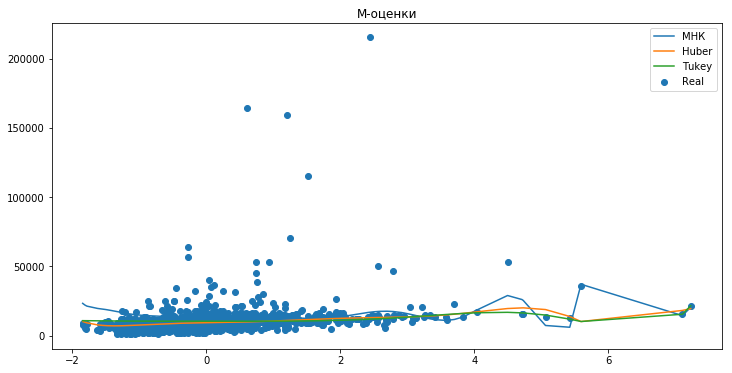

In [31]:
plt.figure(figsize=(12,6))
plt.scatter(X,Y, label='Real')
plt.plot(X,Y_pred_res, label='МНК')
plt.plot(X, Y_pred_huber*Y_std + Y_mean, label='Huber')
plt.plot(X,Y_pred_tukey*Y_std + Y_mean, label='Tukey')
plt.title('М-оценки')
plt.legend()
plt.show()